# Network Analysis of 'MiBici' Public Bike Service in Guadalajara's Metropolitan Area

## Authors:
Henry Marie MONT (C311035) and Matteo MATONE (C40241) 
University of Tartu, Department of Computer Science  
Tartu, Estonia  
Email: henry.marie.mont@ut.ee, matone@ut.ee

## Data exploration

### Import required libraries

In [27]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np

### Load data

In [28]:
# Load MiBici dataset
mibici_df = pd.read_csv('data/mibici_2014-2024/mibici_2014-2024.csv')

# Load nomenclature dataset
nomenclature_df = pd.read_csv('data/nomenclature_2024.csv')

### Explore data

In [29]:
# Display basic information about the nomenclature dataset
print("\nNomenclature Dataset Information:")
print(nomenclature_df.info())

# Display the first few rows of the nomenclature dataset
print("\nFirst few rows of Nomenclature Dataset:")
print(nomenclature_df.head())

# Summary statistics of numerical columns in the nomenclature dataset
print("\nSummary statistics of numerical columns:")
print(nomenclature_df.describe())

# Check for missing values in the nomenclature dataset
print("\nMissing values in Nomenclature Dataset:")
print(nomenclature_df.isnull().sum())

# Display basic information about the MiBici dataset
print("MiBici Dataset Information:")
print(mibici_df.info())

# Display the first few rows of the MiBici dataset
print("\nFirst few rows of MiBici Dataset:")
print(mibici_df.head())

# Summary statistics of numerical columns in the MiBici dataset
print("\nSummary statistics of numerical columns:")
print(mibici_df.describe())

# Check for missing values in the MiBici dataset
print("\nMissing values in MiBici Dataset:")
print(mibici_df.isnull().sum())


Nomenclature Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372 entries, 0 to 371
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         372 non-null    int64  
 1   name       372 non-null    object 
 2   obcn       372 non-null    object 
 3   location   372 non-null    object 
 4   latitude   372 non-null    float64
 5   longitude  372 non-null    float64
 6   status     372 non-null    object 
dtypes: float64(2), int64(1), object(4)
memory usage: 20.5+ KB
None

First few rows of Nomenclature Dataset:
   id                                           name     obcn  \
0   2  (GDL-001) C. Epigmenio Glez./ Av. 16 de Sept.  GDL-001   
1   3     (GDL-002) C. Colonias  / Av.  Niños héroes  GDL-002   
2   4          (GDL-003) C. Vidrio / Av. Chapultepec  GDL-003   
3   5           (GDL-004) C. Ghilardi /C. Miraflores  GDL-004   
4   6  (GDL-005) C. San Diego /Calzada Independencia  GDL-005   

 

In [30]:
# Display unique values for the 'location' column
unique_locations = nomenclature_df['location'].unique()
print("Unique values for 'location' column:")
print(unique_locations)

# Display unique values for the 'status' column
unique_statuses = nomenclature_df['status'].unique()
print("Unique values for 'status' column:")
print(unique_statuses)

Unique values for 'location' column:
['POLÍGONO CENTRAL' 'ZAPOPAN CENTRO' 'TLQ-CORREDORATLAS']
Unique values for 'status' column:
['IN_SERVICE' 'NOT_IN_SERVICE']


### Data preprocessing

In [31]:
# Let's first prune the data as it was way too long to work on those 2.4 GB of data with our machines

# Let's try to keep 1/10th of the data
fraction_to_keep = 0.01

# Calculate the number of rows to keep for each dataset
num_rows_mibici = int(len(mibici_df) * fraction_to_keep)

# Randomly select a subset of rows for each dataset
pruned_mibici_df = mibici_df.sample(n=num_rows_mibici, random_state=42)

# Export the pruned dataset
pruned_mibici_df.to_csv('data/mibici_2014-2024/mibici_compact.csv', index=False)

# Print the shape of the pruned datasets
print("Shape of pruned MiBici dataset:", pruned_mibici_df.shape)

Shape of pruned MiBici dataset: (258636, 11)


In [32]:
# Drop stations that are 'NOT_IN_SERVICE'
nomenclature_df = nomenclature_df[nomenclature_df['status'] != 'NOT_IN_SERVICE']

# Drop the columns 'obcn', 'location', and 'status'
nomenclature_df.drop(columns=['obcn', 'location', 'status'], inplace=True)

In [33]:
# Convert 'Trip_start' and 'Trip_end' columns to datetime objects
pruned_mibici_df['Trip_start'] = pd.to_datetime(pruned_mibici_df['Trip_start'])
pruned_mibici_df['Trip_end'] = pd.to_datetime(pruned_mibici_df['Trip_end'])

# Convert 'Duration' column to numerical format (seconds)
pruned_mibici_df['Duration'] = pd.to_timedelta(pruned_mibici_df['Duration']).dt.total_seconds()

# Extract additional features from datetime columns
pruned_mibici_df['Day_of_week'] = pruned_mibici_df['Trip_start'].dt.dayofweek
pruned_mibici_df['Hour_of_day'] = pruned_mibici_df['Trip_start'].dt.hour
pruned_mibici_df['Month'] = pruned_mibici_df['Trip_start'].dt.month

# Drop unnecessary columns
pruned_mibici_df.drop(columns=['Unnamed: 0', 'User_Id', 'Sex', 'Birth_year', 'Age'], inplace=True)

### Display pre-processed data

In [34]:
# Display basic information about the nomenclature dataset
print("\nNomenclature Dataset Information:")
print(nomenclature_df.info())

# Display the first few rows of the nomenclature dataset
print("\nFirst few rows of Nomenclature Dataset:")
print(nomenclature_df.head())

# Display basic information about the MiBici dataset
print("MiBici Dataset Information:")
print(pruned_mibici_df.info())

# Display the first few rows of the MiBici dataset
print("\nFirst few rows of MiBici Dataset:")
print(pruned_mibici_df.head())


Nomenclature Dataset Information:
<class 'pandas.core.frame.DataFrame'>
Index: 359 entries, 0 to 371
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         359 non-null    int64  
 1   name       359 non-null    object 
 2   latitude   359 non-null    float64
 3   longitude  359 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 14.0+ KB
None

First few rows of Nomenclature Dataset:
   id                                           name   latitude   longitude
0   2  (GDL-001) C. Epigmenio Glez./ Av. 16 de Sept.  20.666378 -103.348820
1   3     (GDL-002) C. Colonias  / Av.  Niños héroes  20.667228 -103.366000
2   4          (GDL-003) C. Vidrio / Av. Chapultepec  20.667690 -103.368252
3   5           (GDL-004) C. Ghilardi /C. Miraflores  20.691750 -103.362550
4   6  (GDL-005) C. San Diego /Calzada Independencia  20.681158 -103.339363
MiBici Dataset Information:
<class 'pandas.core.frame.DataFra

## Building network

In [35]:
# Initialize an empty directed graph
G = nx.DiGraph()

# Add nodes (stations) to the graph from the Nomenclature dataset
for idx, row in nomenclature_df.iterrows():
    G.add_node(row['id'], name=row['name'], latitude=row['latitude'], longitude=row['longitude'])

# Add edges (bike trips) to the graph from the MiBici dataset
for idx, row in pruned_mibici_df.iterrows():
    origin_id = row['Origin_Id']
    destination_id = row['Destination_Id']
    if G.has_node(origin_id) and G.has_node(destination_id):
        # Check if both origin and destination stations exist in the graph
        if G.has_edge(origin_id, destination_id):
            # If an edge already exists, increment the weight (number of trips)
            G[origin_id][destination_id]['weight'] += 1
        else:
            # If no edge exists, add a new edge with weight 1
            G.add_edge(origin_id, destination_id, weight=1)

# Print some basic information about the graph
print("Number of nodes (stations):", G.number_of_nodes())
print("Number of edges (bike trips):", G.number_of_edges())

Number of nodes (stations): 359
Number of edges (bike trips): 37349


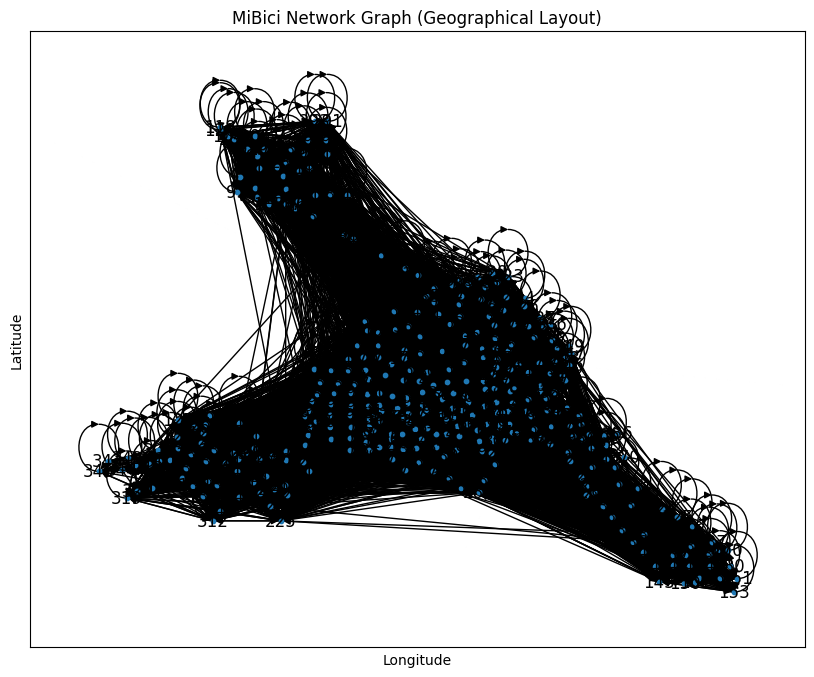

In [36]:
# Define positions for nodes based on latitude and longitude
node_positions = {node_id: (data['longitude'], data['latitude']) for node_id, data in G.nodes(data=True)}

# Draw the network graph with nodes positioned according to latitude and longitude
plt.figure(figsize=(10, 8))
nx.draw_networkx(G, pos=node_positions, with_labels=True, node_size=10)
plt.title('MiBici Network Graph (Geographical Layout)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [37]:
# Basic Entities of a Network
nodes = G.number_of_nodes()
edges = G.number_of_edges()
print("Basic Entities of the Network:")
print("Nodes/Vertices:", nodes)
print("Edges/Connections:", edges)

# Network Metrics
if nx.is_strongly_connected(G):
    # For strongly connected graphs, compute metrics for the largest strongly connected component
    scc = max(nx.strongly_connected_components(G), key=len)
    largest_scc_graph = G.subgraph(scc)
    avg_path_length = nx.average_shortest_path_length(largest_scc_graph)
    try:
        diameter = nx.diameter(largest_scc_graph)
    except nx.NetworkXError:
        diameter = "Diameter computation not applicable for strongly connected graphs"
else:
    # For graphs that are not strongly connected, compute metrics for the largest weakly connected component
    wcc = max(nx.weakly_connected_components(G), key=len)
    largest_wcc_graph = G.subgraph(wcc)
    avg_path_length = nx.average_shortest_path_length(largest_wcc_graph)
    diameter = None

print("\nNetwork Metrics:")
print("Average Path Length:", avg_path_length)
print("Diameter:", diameter)
print("Strongly connected", nx.is_strongly_connected(G))

# Types of Graphs/Networks
# Nodes and Neighbors
nodes = G.nodes()
neighbors = {node: list(G.neighbors(node)) for node in nodes}
print("\nNodes and Neighbors:")
print("Nodes:", nodes)
print("Neighbors:", neighbors)

# Node Degree Distribution
degree_distribution = nx.degree_histogram(G)
print("\nNode Degree Distribution:")
print(degree_distribution)

# Connected Component
connected_components = wcc if not nx.is_strongly_connected(G) else scc
print("\nConnected Components:")
print(connected_components)

# Dyads
reciprocity = nx.reciprocity(G) if nx.is_directed(G) else None
density = nx.density(G)
print("\nDyads:")
print("Reciprocity:", reciprocity)
print("Density:", density)

# Triads
clustering_coefficient = nx.average_clustering(G)
print("\nTriads:")
print("Clustering Coefficient:", clustering_coefficient)

# K-cores
G.remove_edges_from(nx.selfloop_edges(G))  # Remove self-loops
k_cores = nx.core_number(G)
print("\nK-cores:")
print(k_cores)

# Assortativity and Disassortativity
assortativity = nx.degree_assortativity_coefficient(G)
print("\nAssortativity:")
print("Assortativity Coefficient:", assortativity)

Basic Entities of the Network:
Nodes/Vertices: 359
Edges/Connections: 37349

Network Metrics:
Average Path Length: 1.8143897542833134
Diameter: None
Strongly connected False

Nodes and Neighbors:
Nodes: [2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 91, 92, 93, 94, 95, 96, 98, 100, 101, 102, 103, 104, 105, 106, 107, 108, 110, 111, 112, 115, 117, 118, 119, 120, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 139, 140, 141, 142, 143, 144, 145, 146, 148, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 

### Preprocessing nodes in the graph

In [38]:
# Calculate the average degree of the graph
average_degree = sum(dict(G.degree()).values()) / len(G)

print("Average degree of the graph:", average_degree)

Average degree of the graph: 206.3008356545961


In [39]:
# Get the degrees of nodes in the graph
degrees = list(dict(G.degree()).values())

# Calculate the lower quartile (Q1) using numpy's percentile function
lower_quartile = np.percentile(degrees, 25)

print("Lower quartile (Q1) of the node degrees:", lower_quartile)

Lower quartile (Q1) of the node degrees: 72.0


In [40]:
# Remove disconnected nodes
G.remove_nodes_from(list(nx.isolates(G)))

# Remove nodes with a low number of edges (e.g., less than 2)
nodes_to_remove = [node for node, degree in dict(G.degree()).items() if degree < 74]
G.remove_nodes_from(nodes_to_remove)

# Print some basic information about the graph after pre-processing
print("Number of nodes after pre-processing:", G.number_of_nodes())
print("Number of edges after pre-processing:", G.number_of_edges())

Number of nodes after pre-processing: 266
Number of edges after pre-processing: 34391


In [41]:
# Create an empty graph
G_by_year = nx.Graph()

# Group the DataFrame by origin, destination, and year
grouped_df = pruned_mibici_df.groupby(['Origin_Id', 'Destination_Id', pruned_mibici_df['Trip_start'].dt.year])

# Iterate over each group
for (origin, destination, year), group_data in grouped_df:
    # Calculate the total number of trips for this group
    total_trips = len(group_data)
    
    # Check if an edge between the origin and destination already exists
    if G_by_year.has_edge(origin, destination):
        # Check if an edge with the specified year exists
        if G_by_year[origin][destination].get(year):
            # If the edge with the specified year exists, update its weight
            G_by_year[origin][destination][year]['weight'] += total_trips
        else:
            # If the edge with the specified year does not exist, add a new edge
            G_by_year.add_edge(origin, destination, year=year, weight=total_trips)
    else:
        # If the edge between the origin and destination does not exist, add a new edge
        G_by_year.add_edge(origin, destination, year=year, weight=total_trips)

# Print the number of nodes and edges for the graph by year
print("Graph based on year: Nodes:", G_by_year.number_of_nodes(), "Edges:", G_by_year.number_of_edges())


Graph based on year: Nodes: 372 Edges: 23329


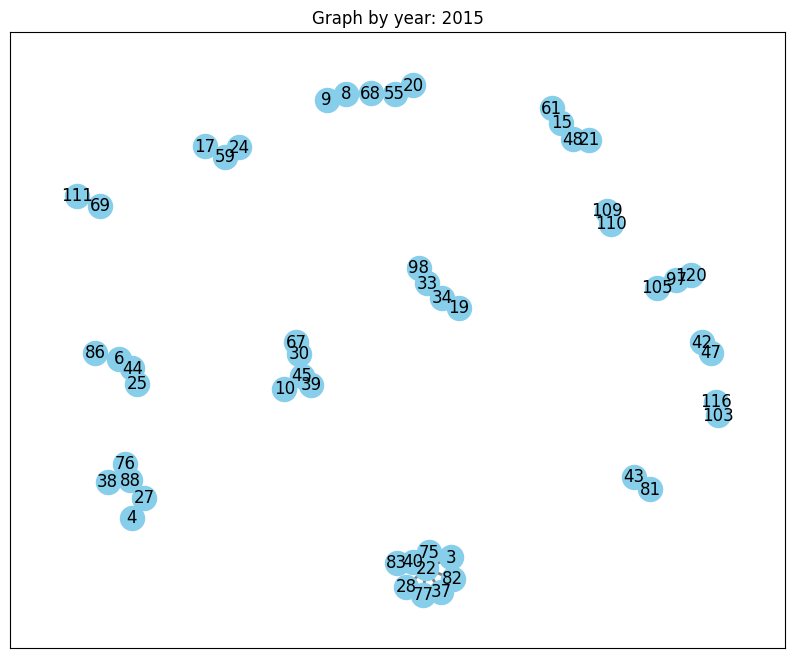

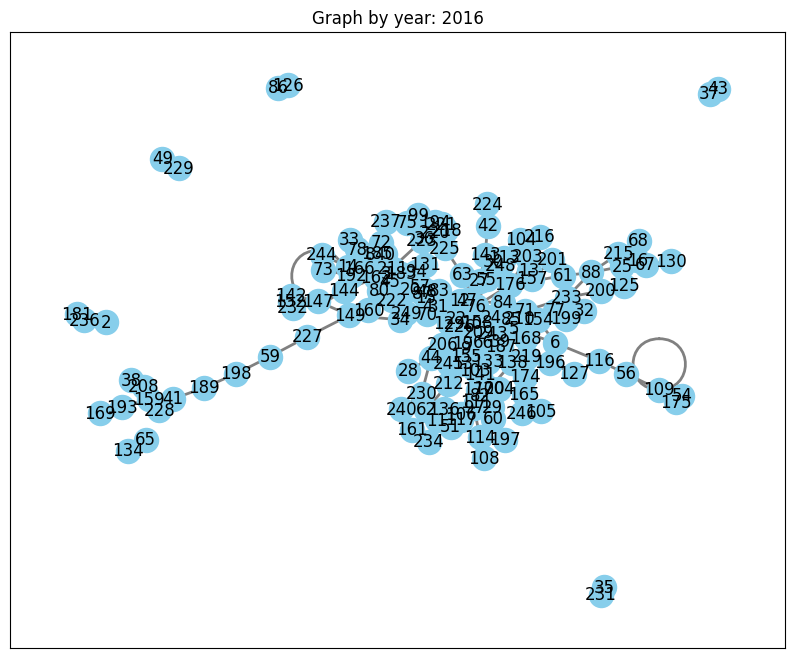

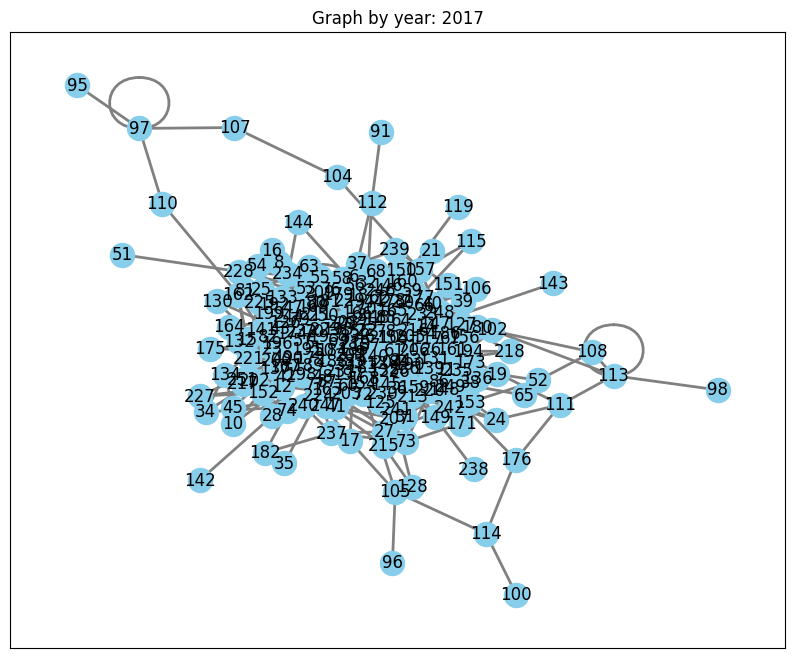

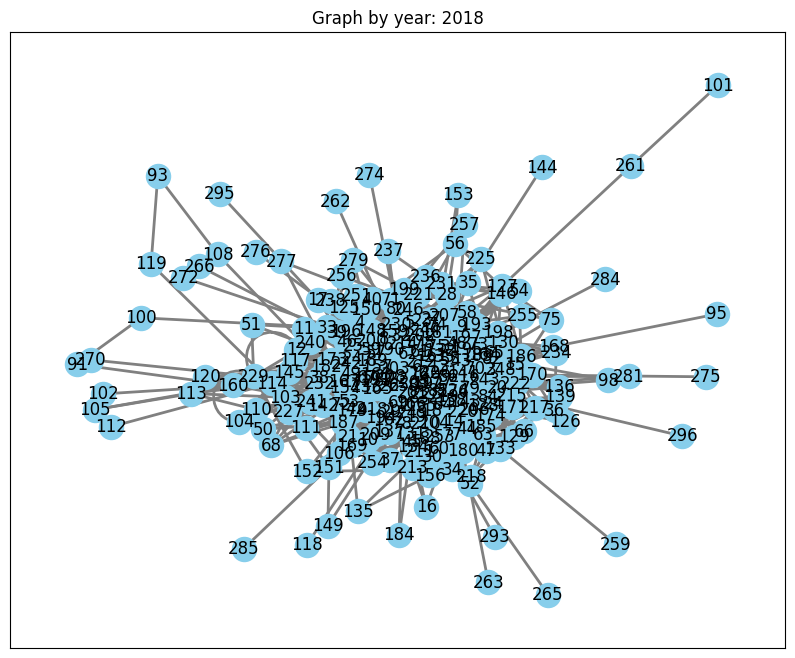

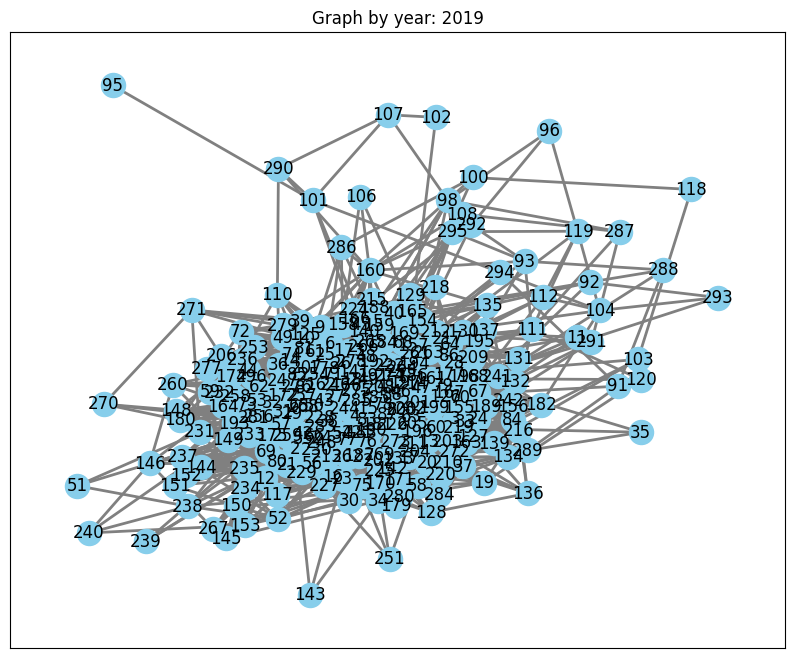

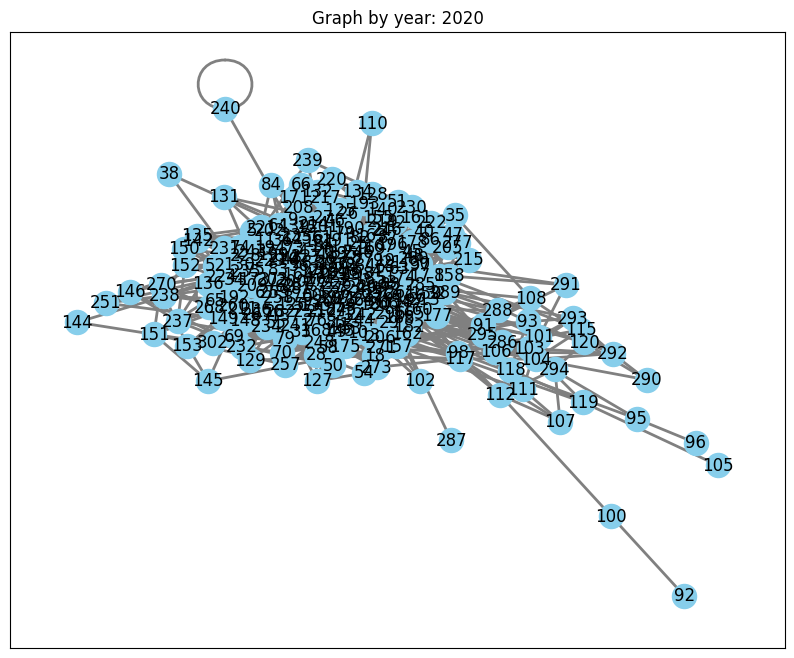

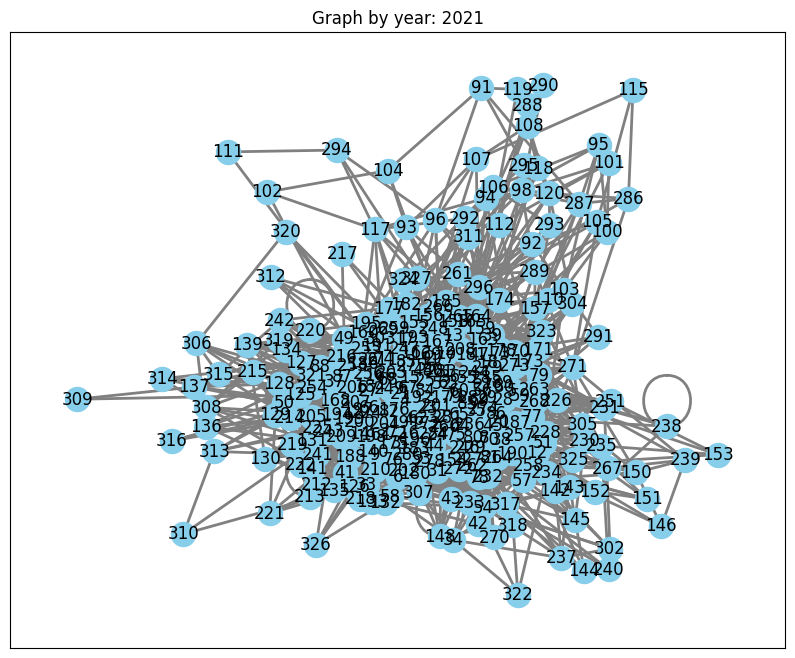

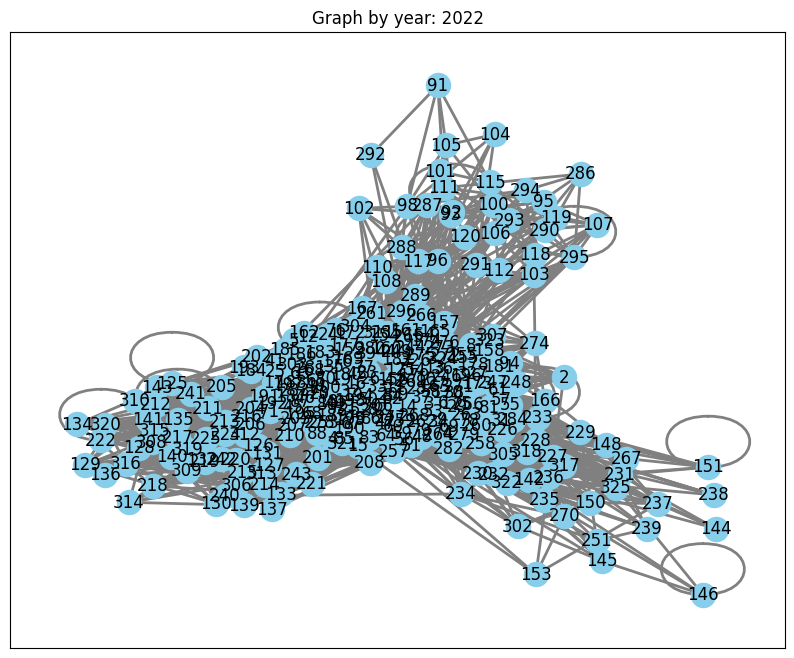

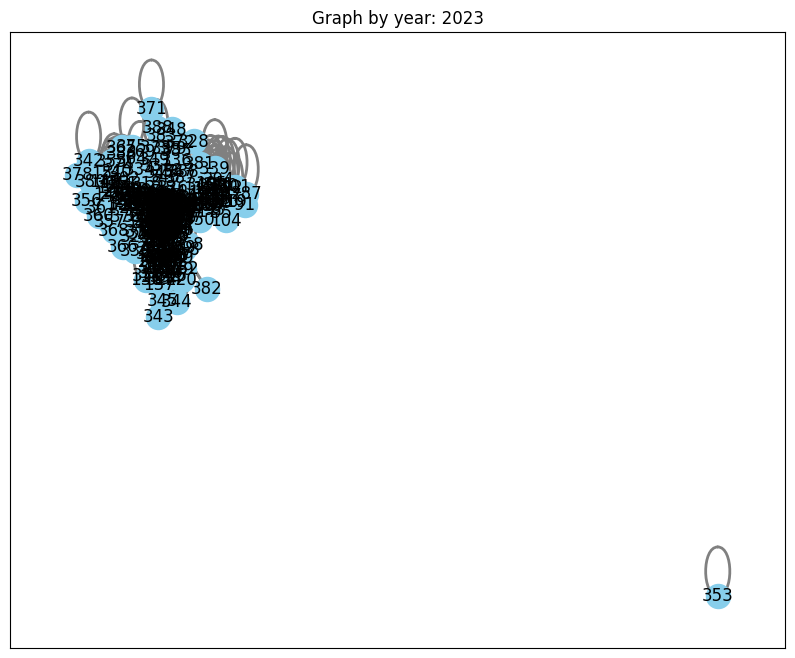

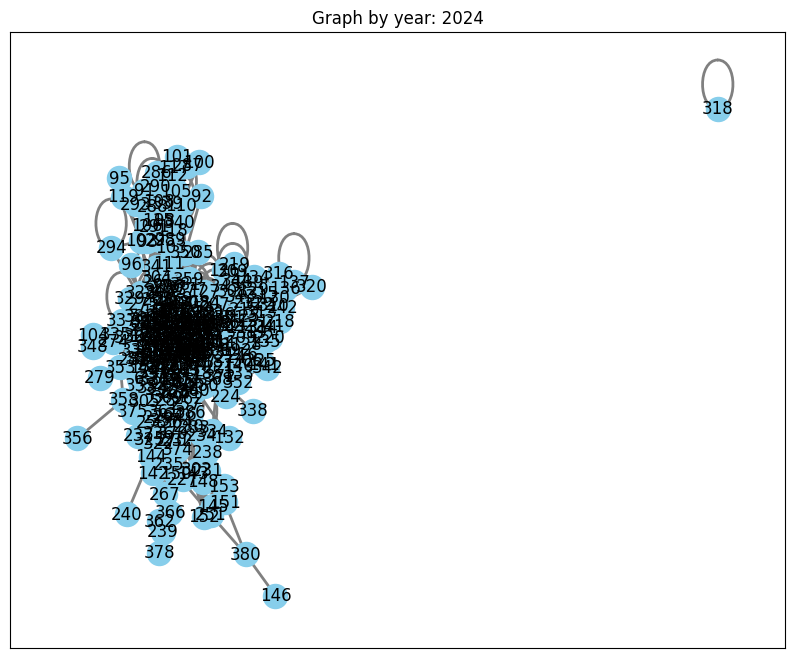

In [42]:
# Get a list of unique years
unique_years = sorted(set(nx.get_edge_attributes(G_by_year, 'year').values()))

# Plot the graph for each year
for year in unique_years:
    # Create a subgraph containing edges from the given year
    subgraph_edges = [(u, v) for u, v, attrs in G_by_year.edges(data=True) if attrs['year'] == year]
    subgraph = G_by_year.edge_subgraph(subgraph_edges)
    
    # Draw the subgraph
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(subgraph)  # Define the layout (you can use other layouts as well)
    nx.draw_networkx(subgraph, pos, with_labels=True, node_size=300, node_color='skyblue', edge_color='gray', width=2)
    plt.title(f"Graph by year: {year}")
    plt.show()